In [25]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go


import warnings
warnings.filterwarnings('ignore')

In [26]:
def file_info(site_id,plot_decompose=False):
    index=site_ids.index(site_id)
    df=pd.read_csv(csv_files[index])
    print('Site_Name:',df['siteName'].values[0])
    print('Min:',df['PM2.5'].min())
    print('Mean:',df['PM2.5'].mean())
    print('Max:',df['PM2.5'].max())
    if plot_decompose:
        result = seasonal_decompose(df['PM2.5'].dropna(), model='additive', period=365*4*24)
        result.plot()
        plt.show()

In [27]:
def fit_poly(df,scale_to=1400,to_plot=True):
    df=df.sort_values(by='x',ascending=True).reset_index(drop=True)
    x=(df['x']-df.x[0])
    sc=scale_to/x.values[-1]
    x=x*sc
    y=df[' y']
    degree=50
    coefficients = np.polyfit(x, y, degree)
    poly_func = np.poly1d(coefficients)
    if to_plot:
        plt.scatter(x, y, label="Data")
        x_fit = np.linspace(0, max(x), len(x))
        y_fit = poly_func(x_fit)
        plt.plot(x_fit, y_fit,'k--' ,label="Fitted Polynomial Curve")
    return poly_func

In [28]:
np.random.seed(100)
def generate_data(poly_funcs,num_series=10,sr=1,t=365*2,noise_std=3):
    """
    poly_funcs : Contains 'n' number of Trends which is used to assign label
    sr : Sampling rate in units of days (1 unit= 1day)
    num_pts : Number of points
    """
    time_vec = np.linspace(1/sr,t, sr*t) #time vector
    npnts = t*sr #number of points in signal
    data = np.zeros((num_series, npnts)) #initialize data matrix
    data_labels = np.zeros(num_series) #initialize label matrix

    for n in range(num_series):
        signal_type = np.random.choice(np.arange(0,len(poly_funcs)), size = 1)[0] 
        data_labels[n] =signal_type # save event type to data_label matrix

        trend_comp = poly_funcs[signal_type](time_vec)
        seasonal_comp=0
        for _ in range(5):
            # Sin Curve
            if np.random.choice([0,1],size=1)[0]==0:
                ph_amp=[0,0,1.5,1.75,1,1.5,1.25,1.75,2,2.25]
                ph_shift=[0,np.pi/10,np.pi/8,np.pi/9,np.pi/12]
                freq=[350,90,380,210,360]
                a,b,c=np.random.choice(np.arange(0,len(ph_amp)),size=1)[0],np.random.choice(np.arange(0,len(ph_shift)),size=1)[0],np.random.choice(np.arange(0,len(freq)),size=1)[0]
                st=1/freq[c] # Seasonal Timeperiod
                seasonal_comp+=ph_amp[a]*np.sin(2 * np.pi * time_vec*st + ph_shift[b])
            # Cos Curve
            else:
                ph_amp=[0,0,0.5,0.5,1.75,1,1.25,1.5,2.25,3,2.75]
                ph_shift=[0,np.pi/10,np.pi/8,np.pi/9,np.pi/12]
                freq=[360,200,180,150,240]
                a,b,c=np.random.choice(np.arange(0,len(ph_amp)),size=1)[0],np.random.choice(np.arange(0,len(ph_shift)),size=1)[0],np.random.choice(np.arange(0,len(freq)),size=1)[0]
                st=1/freq[c] # Seasonal Timeperiod
                seasonal_comp+=ph_amp[a]*np.cos(2 * np.pi * time_vec*st + ph_shift[b])


        noise_comp = np.random.normal(0,noise_std ,npnts)
        shift=np.random.choice(np.arange(0,10),size=1)[0]

        data[n,:]=trend_comp+seasonal_comp+noise_comp+shift

    return time_vec,data,data_labels

In [29]:
path="D:\\BTP\\Data\\trends_synthetic_case"
df_trend1=pd.read_csv(f"{path}/Trend_GandhiNagar_Gujarat.csv")
df_trend1

,x,y
0,13750.000813,35.918367
1,13750.000813,35.918367
2,13977.274377,35.561224
3,14431.817172,34.948978
4,14886.364301,34.489796
...,...,...
229,126931.806877,34.234694
230,127045.450161,34.081633
231,131022.722371,33.112244
232,131477.260831,33.418366


In [30]:
df_trend1=pd.read_csv(f"{path}/Trend_GandhiNagar_Gujarat.csv")
df_trend2=pd.read_csv(f"{path}/Trend_Bangalore.csv")
df_trend3=pd.read_csv(f"{path}/Trend_Gangapur.csv")
df_trend4=pd.read_csv(f"{path}/Trend_Velachery.csv")

df_trend1[' y']=df_trend1[' y']-5
len_ts=365*5

[]

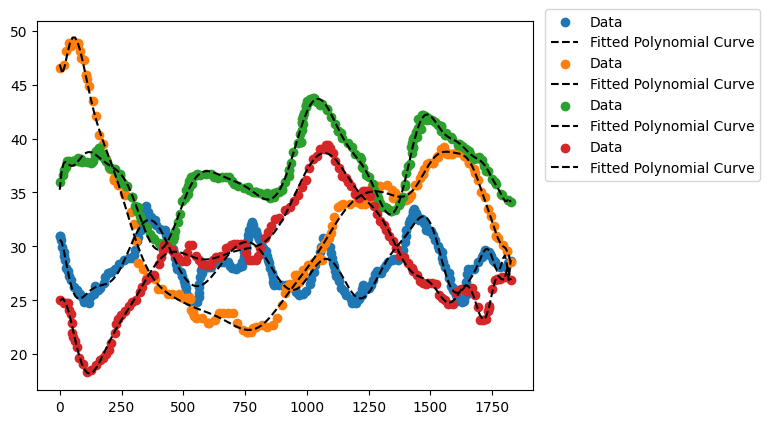

In [31]:
poly1=fit_poly(df_trend1,scale_to=len_ts)
poly2=fit_poly(df_trend2,scale_to=len_ts)
poly3=fit_poly(df_trend3,scale_to=len_ts)
poly4=fit_poly(df_trend4,scale_to=len_ts)


plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.plot()

In [32]:
time, data, data_labels = generate_data(poly_funcs=[poly1,poly2,poly3,poly4],num_series=40,noise_std=3,t=len_ts)

In [33]:
import plotly.graph_objects as go

df=pd.DataFrame(data)
df['labels']=data_labels
df.sort_values(by='labels',inplace=True)
colors=['violet','greenyellow','skyblue','khaki','crimson']
group_names=['Group_'+str(i+1) for i in range(int(pd.DataFrame(data_labels).max()[0]+1))]
fig = go.Figure()
k=-1
for ind,row in df.iterrows():
            if k!=row['labels']:
                k=row['labels']
                j=0
            fig.add_trace(go.Scatter(x=np.arange(len(row)-1),y=row[:-1], mode='lines', line=dict(color=colors[int(k)]), name=group_names[int(k)],legendgroup=group_names[int(k)],showlegend=(j==0)))
            j+=1
fig.show()

In [34]:
df['labels'].value_counts()

labels
2.0    12
1.0    10
3.0    10
0.0     8
Name: count, dtype: int64

In [35]:
df=df.reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,1816,1817,1818,1819,1820,1821,1822,1823,1824,labels
0,35.218993,34.444695,40.358653,38.975589,38.144522,36.876874,38.033091,31.005685,36.667117,32.324407,...,26.166304,28.328713,34.905516,32.186676,28.736112,27.519475,26.038595,26.544289,30.825966,0.0
1,33.626218,32.794041,33.822114,33.844290,31.775779,36.411681,32.014205,33.739033,36.735700,35.106703,...,22.779389,31.160291,23.745474,30.231758,29.491379,26.076705,28.488901,28.413565,30.652148,0.0
2,30.029777,38.964292,36.329600,35.774250,42.155281,42.875285,33.369191,35.914541,31.052544,36.075171,...,30.386289,28.977915,32.841000,29.838487,31.621647,29.444939,26.352408,27.753728,41.408827,0.0
3,49.712755,45.088134,43.713469,39.858292,43.658400,40.760305,37.321808,39.204449,44.359655,43.738493,...,36.097938,35.812423,30.179285,33.446042,31.591168,32.133161,35.958567,33.240198,30.035505,0.0
4,41.563532,48.541324,45.252775,42.765353,47.743760,39.345850,41.777998,41.729365,49.539636,39.064670,...,36.381688,34.598383,36.599370,39.468415,31.985547,34.195901,32.318115,36.349879,34.765891,0.0
5,39.911077,38.750265,37.389196,37.594769,41.146048,35.431776,36.618031,35.792260,34.244084,34.698861,...,28.428448,29.671876,27.801470,25.202512,27.552182,26.556489,25.697817,28.696267,29.057063,0.0
6,46.872787,41.881033,46.061134,45.021020,45.448410,47.594729,45.950484,45.989668,45.854362,42.538044,...,36.065844,36.516527,31.638842,37.536859,38.089496,35.767395,39.699024,33.522020,37.077877,0.0
7,38.036008,43.172591,41.966465,39.060321,38.223887,43.543902,39.936826,45.613505,41.804452,36.587070,...,26.556756,32.154062,37.083837,35.832020,39.107815,31.400929,40.118805,38.611949,33.364832,0.0
8,55.892358,58.266678,53.683019,55.934408,56.556960,54.399115,54.728457,52.882654,57.341501,57.127678,...,38.834652,37.045102,39.431175,38.527589,36.432002,37.798443,40.021009,38.625340,40.080479,1.0
9,52.239264,56.269406,50.393511,52.399520,51.785958,52.401235,54.783641,53.702781,51.098246,55.929021,...,30.193241,35.236102,30.394056,32.543734,31.184764,26.015809,33.519818,31.279772,31.070833,1.0


In [36]:
df=df.sample(frac=1).reset_index(drop=True)
df.to_csv(f"{path}/Data_40_series_k4.csv",index=False)